# Equi Boots Graphical Notebook

## Library Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /home/afunnell/Code/EquiBoots/equi_boots/py_scripts


In [2]:
import equiboots as eqb

## Main

In [7]:
# Generate synthetic test data
y_prob = np.random.rand(1000)
y_pred = y_prob > 0.5
y_true = np.random.randint(0, 2, 1000)

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

eq2 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=100,
    balanced=False,  # False is stratified, True is balanced
)

# Set seeds
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()

eq2.set_fix_seeds(int_list)

print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

data = eq2.slicer("race")

race_metrics = eq2.get_metrics(data)

dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])

Groups created
seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 271.36it/s]

Groups created


In [9]:
df

,Accuracy_ratio,Precision_ratio,Recall_ratio,F1 Score_ratio,Specificity_ratio,TP Rate_ratio,FP Rate_ratio,FN Rate_ratio,TN Rate_ratio,Prevalence_ratio,Predicted Prevalence_ratio,ROC AUC_ratio,Average Precision Score_ratio,Log Loss_ratio,Brier Score_ratio,attribute_value
0,1.516667,1.272727,2.250000,1.820000,1.000000,2.250000,1.000000,0.642857,1.000000,0.907407,1.604167,1.146718,0.998863,0.769199,0.830698,asian
1,1.633333,1.250000,1.500000,1.363636,1.857143,1.500000,0.619048,0.666667,1.857143,0.777778,0.933333,1.260204,0.901412,0.949890,0.875678,asian
2,0.859649,1.222222,0.952381,1.076923,0.830769,0.952381,1.440000,1.071429,0.830769,1.633333,1.272727,0.615694,0.781581,1.780857,1.728868,asian
3,0.947917,1.083333,1.000000,1.040000,0.909091,1.000000,1.136364,1.000000,0.909091,1.166667,1.076923,0.636364,0.762380,1.463583,1.477605,asian
4,1.166667,2.375000,0.807692,1.620370,1.142857,0.807692,0.933333,1.384615,1.142857,2.527778,0.859649,0.730769,1.223975,0.947253,0.945307,asian
5,0.686275,0.738636,0.673077,0.703125,0.707071,0.673077,1.527273,1.435897,0.707071,1.083333,0.987179,0.802621,0.948812,1.371036,1.183640,asian
6,0.982456,1.000000,1.076923,1.045455,0.954545,1.076923,1.272727,0.923077,0.954545,1.083333,1.166667,0.994189,1.009055,1.137367,0.981874,asian
7,1.166667,2.250000,1.406250,1.800000,0.843750,1.406250,1.125000,0.729167,0.843750,1.866667,1.166667,1.166888,1.761550,0.907611,0.883814,asian
8,1.101852,1.153846,1.071429,1.111111,1.137500,1.071429,0.780000,0.857143,1.137500,1.088889,1.011111,1.013918,0.856616,0.854046,0.957176,asian
9,1.244444,1.339286,1.250000,1.294643,1.200000,1.250000,0.800000,0.666667,1.200000,1.166667,1.088889,1.536585,1.357988,0.791287,0.746336,asian


## Disparity Plots

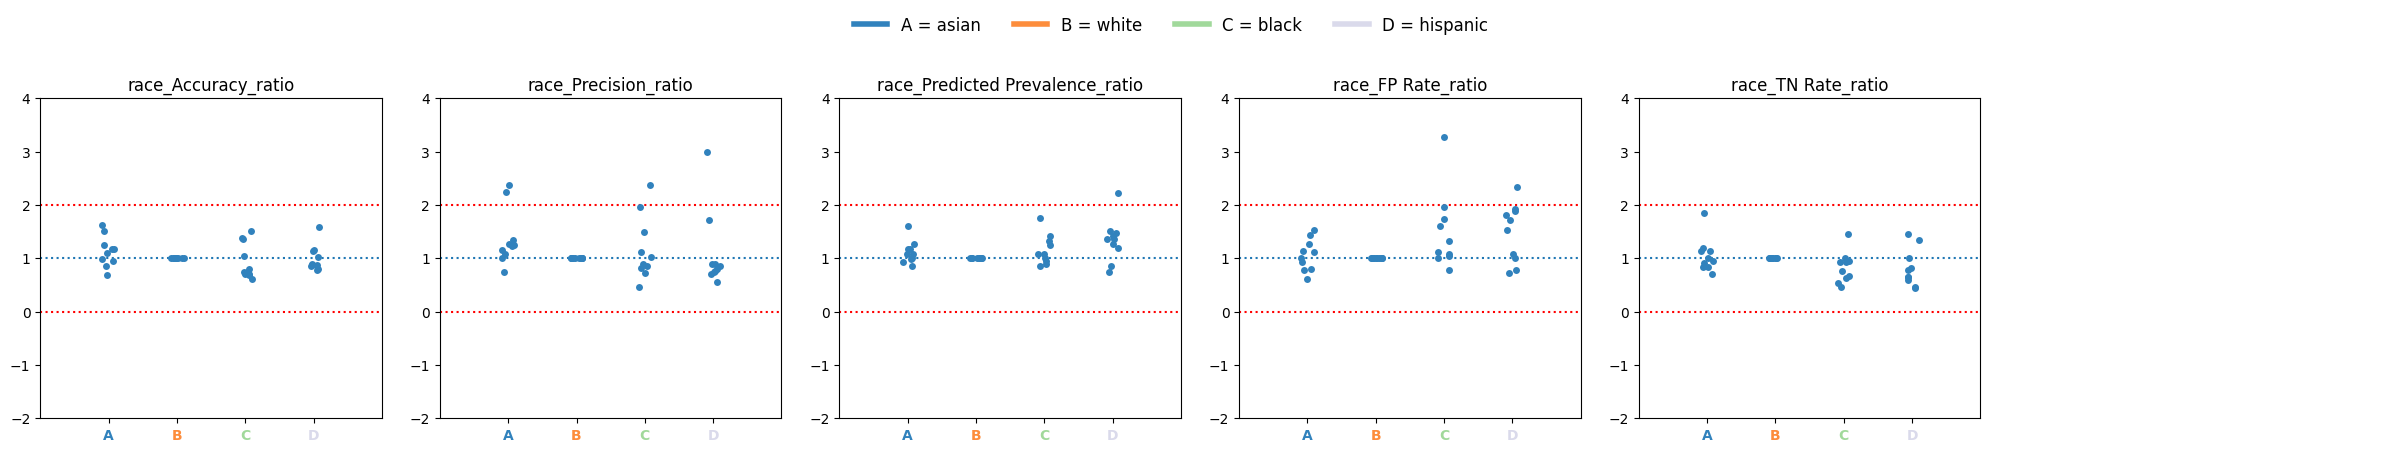

In [16]:
eqb.eq_disparity_metrics_plot(
    dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "FP Rate_ratio",
        "TN Rate_ratio",
    ],
    name="race",
    categories="all",
    figsize=(24, 4),
    plot_kind="stripplot",
)

## ROC AUC by Group (ex. Race)

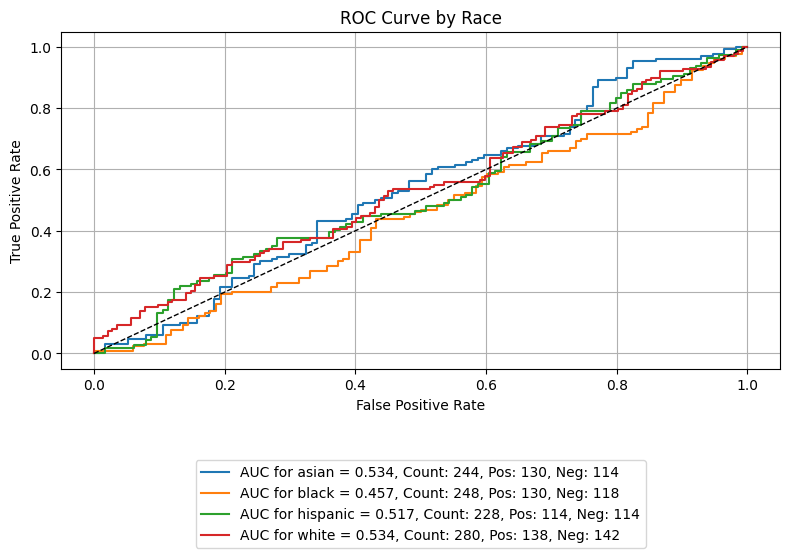

In [11]:
eqb.eq_plot_roc_auc(
    data=sliced_data,
    title="ROC Curve by Race",
    decimal_places=3,
)

## Precision-Recall Curves

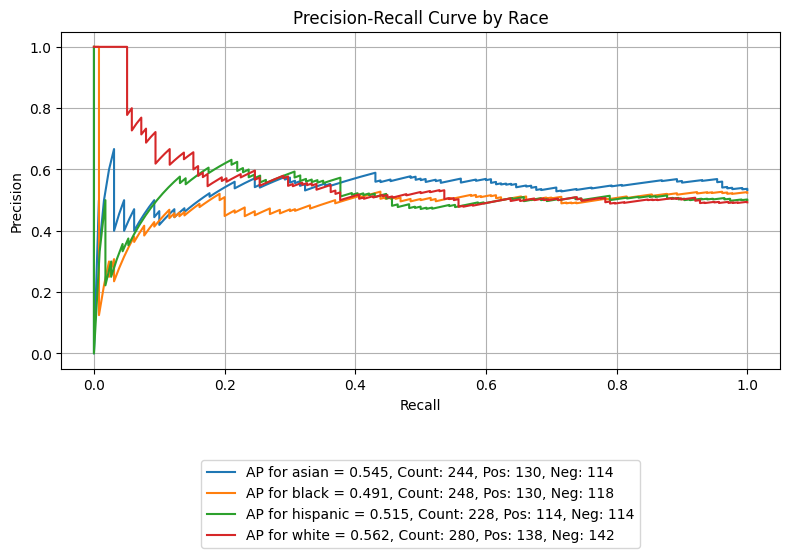

In [12]:
# Precision-Recall plot
fig2 = eqb.eq_plot_precision_recall(
    data=sliced_data,
    title="Precision-Recall Curve by Race",
    # tick_fontsize=8,
    decimal_places=3,
    dpi=100,
)

## Calibration Plot

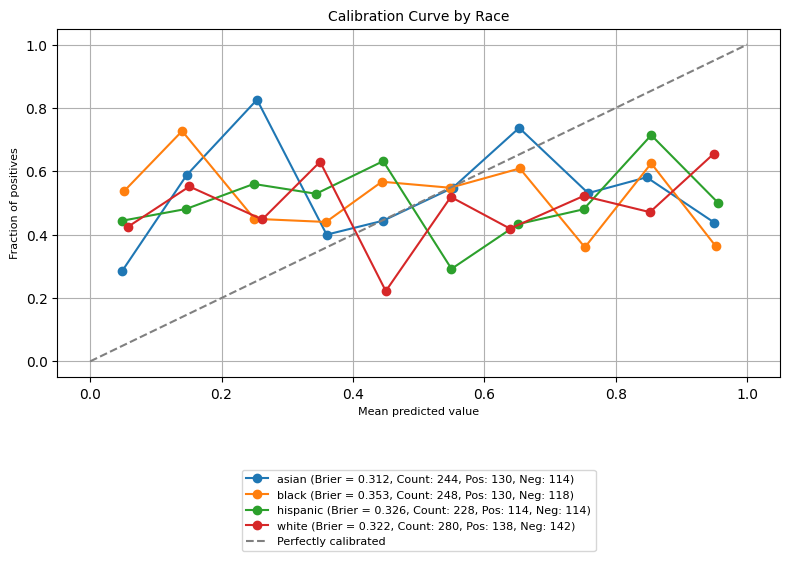

In [13]:
# Calibration plot
fig3 = eqb.eq_calibration_curve_plot(
    data=sliced_data,
    n_bins=10,
    title="Calibration Curve by Race",
    tick_fontsize=8,
    decimal_places=3,
)
fig3